In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the data
file_path = '/content/drive/My Drive/Thesis/Subject3.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

In [3]:
# Preprocess - Round to nearest 5 minutes
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')

# Filter out rows where mg/dl is > 400 or missing values
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])

# Drop duplicates and sort
cgm_data = cgm_data.drop_duplicates(subset='date').reset_index(drop=True)
cgm_data = cgm_data.sort_values(by='date').reset_index(drop=True)

In [4]:
# Generate AR Features (using past 12 readings as input)
num_lags = 12 # Using the past 12 values
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

cgm_data = cgm_data.dropna().reset_index(drop=True)

In [5]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Feed Forward Neural Network with Only Blood Glucose

In [6]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7854/7854 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 5057.3511 - mae: 45.6399 - val_loss: 629.6665 - val_mae: 17.0984
Epoch 2/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1275.1078 - mae: 26.3068 - val_loss: 579.4252 - val_mae: 16.3653
Epoch 3/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1212.2303 - mae: 25.4574 - val_loss: 556.8825 - val_mae: 16.0040
Epoch 4/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1151.8837 - mae: 24.8125 - val_loss: 554.8690 - val_mae: 15.9907
Epoch 5/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1098.5640 - mae: 24.0603 - val_loss: 509.1344 - val_mae: 15.4029
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 483.7824 - mae: 14.7437
Test Loss: 492.82586669921875, Test MAE: 14.898603439331055
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 22.199684451618147


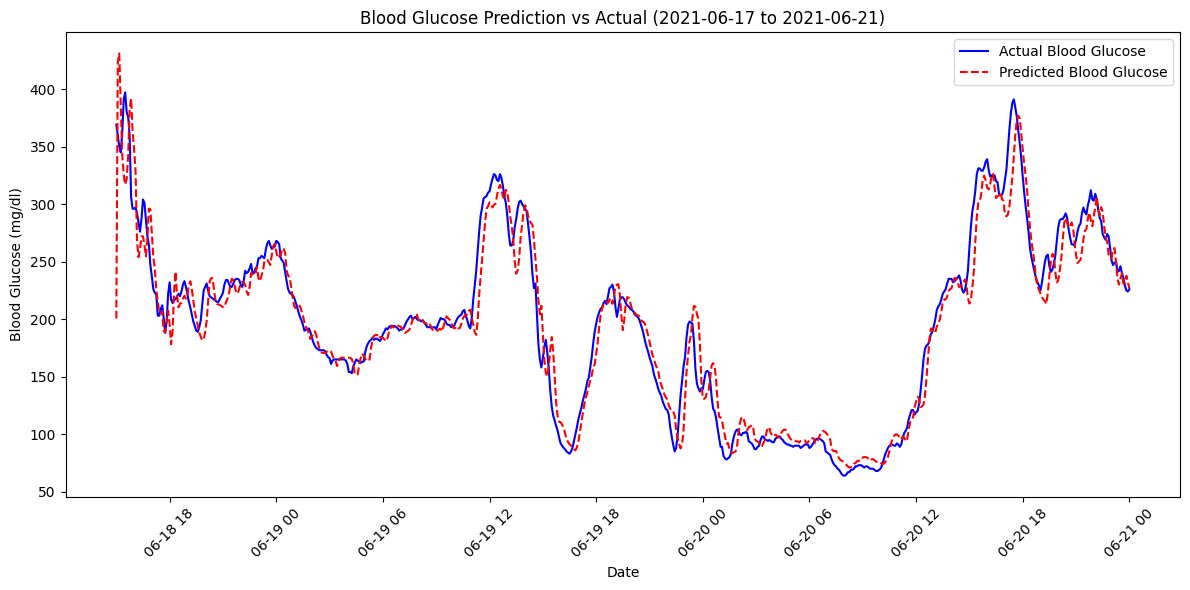

In [8]:
import matplotlib.pyplot as plt

# Add 'date' to the test data for plotting
test_dates = cgm_data['date'][train_size:].reset_index(drop=True)

# Function to plot actual vs predicted values for a specific week
def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    # Create a DataFrame for easier manipulation
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    # Filter data for the given date range
    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify the start and end date for the week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions for the specified week
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)


6

In [9]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 6  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7854/7854 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 5202.2241 - mae: 48.1695 - val_loss: 1236.5017 - val_mae: 24.8753
Epoch 2/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1723.3311 - mae: 30.7418 - val_loss: 1214.5883 - val_mae: 24.3370
Epoch 3/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 1655.6997 - mae: 29.9667 - val_loss: 1217.1775 - val_mae: 24.4970
Epoch 4/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 1597.1790 - mae: 29.3669 - val_loss: 1153.5229 - val_mae: 23.6674
Epoch 5/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 1553.2393 - mae: 28.9029 - val_loss: 1195.1609 - val_mae: 24.0823
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1160.5665 - mae: 23.2794
Test Loss: 1188.276611328125, Test MAE: 23.4864559173584
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 34.471406526056455


9

In [12]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 9  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7854/7854 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 5726.0166 - mae: 52.3338 - val_loss: 2055.0649 - val_mae: 32.5709
Epoch 2/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 2236.8447 - mae: 35.4368 - val_loss: 1848.5881 - val_mae: 31.8138
Epoch 3/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 2154.2461 - mae: 34.6564 - val_loss: 1950.6458 - val_mae: 31.5652
Epoch 4/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 2118.7415 - mae: 34.2159 - val_loss: 1842.3461 - val_mae: 30.7056
Epoch 5/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 2063.3169 - mae: 33.6922 - val_loss: 1800.0726 - val_mae: 30.4128
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1740.7529 - mae: 29.4255
Test Loss: 1790.7265625, Test MAE: 29.830833435058594
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 42.31699361079679


12

In [15]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 12  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [16]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7854/7854 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 6090.8979 - mae: 55.0932 - val_loss: 2700.6152 - val_mae: 38.1063
Epoch 2/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 2686.7473 - mae: 39.1500 - val_loss: 2566.3816 - val_mae: 37.0593
Epoch 3/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 2604.9978 - mae: 38.5223 - val_loss: 2552.8879 - val_mae: 36.8408
Epoch 4/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 2541.8123 - mae: 37.9173 - val_loss: 2607.7612 - val_mae: 37.2237
Epoch 5/5
7854/7854 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2517.6187 - mae: 37.6957 - val_loss: 2669.0337 - val_mae: 37.4929
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2672.3782 - mae: 37.0793
Test Loss: 2736.017578125, Test MAE: 37.25389862060547
2455/2455 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 52.30698295830234


Feed Forward Neural Network with Blood Glucose and Bolus

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error

# Load CGM and Bolus data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')

In [19]:
# Preprocess CGM data
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Preprocess Bolus data
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for CGM (past glucose readings)
num_lags = 12  # Number of past readings to use
for lag in range(1, num_lags + 1):
    merged_data[f'lag_{lag}'] = merged_data['mg/dl'].shift(lag)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommended.carb',
              'recommended.net', 'recommended.correction', 'insulinSensitivityFactor',
              'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [20]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 3  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<ipython-input-20-2e8ff43a49a4>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)


In [21]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 3277.4072 - mae: 36.5516 - val_loss: 460.6701 - val_mae: 14.6015
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 1046.1704 - mae: 23.8792 - val_loss: 422.3006 - val_mae: 14.0014
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 980.7632 - mae: 23.0501 - val_loss: 404.1031 - val_mae: 13.5292
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 935.7312 - mae: 22.3970 - val_loss: 415.1485 - val_mae: 14.0466
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 897.2142 - mae: 21.8948 - val_loss: 483.4707 - val_mae: 15.5754
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 426.1320 - mae: 14.8087
Test Loss: 409.101318359375, Test MAE: 14.392955780029297
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Root Mean Squared Error (RMSE): 20.226241374317482


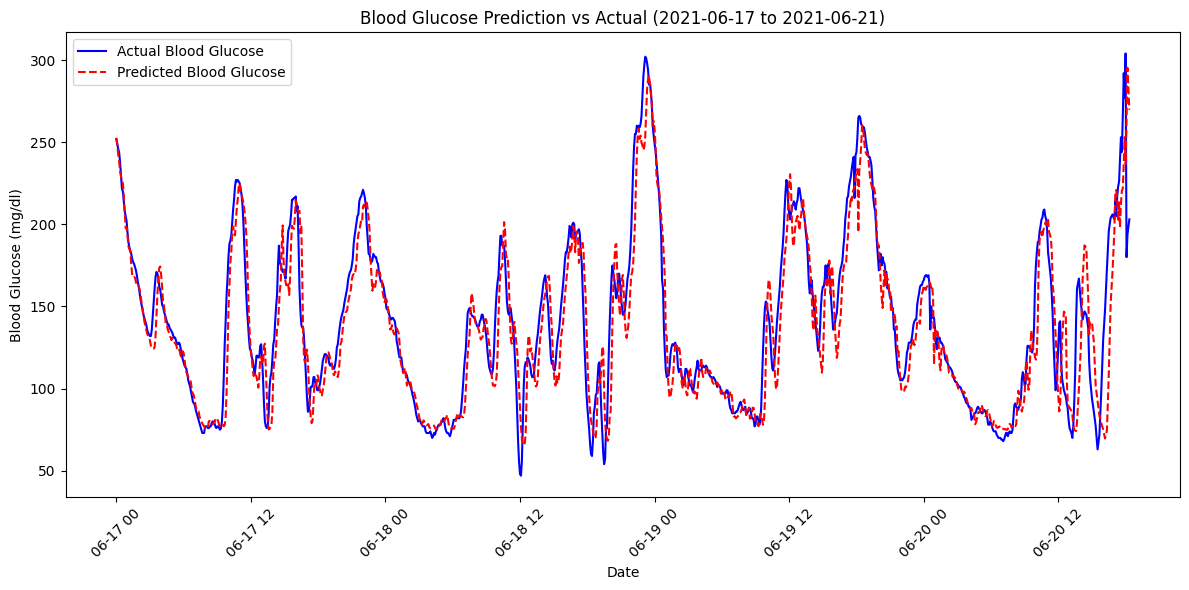

In [22]:
def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify dates for a week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)

6

In [23]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 6  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [24]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 3847.6138 - mae: 42.0178 - val_loss: 1007.0625 - val_mae: 22.5667
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 1587.2025 - mae: 29.7314 - val_loss: 1084.8610 - val_mae: 23.8996
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 1519.0520 - mae: 29.0364 - val_loss: 996.9844 - val_mae: 22.5174
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1479.3662 - mae: 28.4924 - val_loss: 900.2678 - val_mae: 21.0390
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 1419.6085 - mae: 27.8914 - val_loss: 925.2218 - val_mae: 21.7472
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 835.7591 - mae: 20.7983
Test Loss: 829.7846069335938, Test MAE: 20.726408004760742
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Root Mean Squared Error (RMSE): 28.80598591493759


9

In [25]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 9  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [26]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 4201.0864 - mae: 45.4802 - val_loss: 1572.8812 - val_mae: 28.9556
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 2084.2825 - mae: 34.4059 - val_loss: 1544.4685 - val_mae: 28.7153
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 2021.2904 - mae: 33.8211 - val_loss: 1493.2572 - val_mae: 28.1322
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 1981.7218 - mae: 33.3830 - val_loss: 1471.5598 - val_mae: 27.8671
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 1952.0271 - mae: 33.1230 - val_loss: 1498.6981 - val_mae: 28.1001
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1369.0420 - mae: 26.9512
Test Loss: 1347.3145751953125, Test MAE: 26.808982849121094
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Root Mean Squared Error (RMSE): 36.705777426207774


12

In [27]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 12  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [28]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 4937.0474 - mae: 50.6826 - val_loss: 2224.7903 - val_mae: 35.3662
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 2704.1812 - mae: 39.6842 - val_loss: 2234.4482 - val_mae: 35.5233
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 2629.8403 - mae: 39.0647 - val_loss: 2109.9573 - val_mae: 34.4308
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 2585.9705 - mae: 38.6639 - val_loss: 2143.6851 - val_mae: 34.8271
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 2543.2908 - mae: 38.3104 - val_loss: 2016.5367 - val_mae: 33.5596
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1854.7224 - mae: 32.2894
Test Loss: 1820.22509765625, Test MAE: 32.03440475463867
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Root Mean Squared Error (RMSE): 42.66408853771438


LSTM with Blood Glucose and Bolus Data

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load CGM and Bolus data (same preprocessing steps as before)
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')

# Preprocess CGM data
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Preprocess Bolus data
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for CGM and Bolus variables
num_lags = 12
for lag in range(1, num_lags + 1):
    merged_data[f'lag_{lag}'] = merged_data['mg/dl'].shift(lag)

bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommended.carb',
              'recommended.net', 'recommended.correction', 'insulinSensitivityFactor',
              'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)



<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [30]:
# Generate target variable
forecast_horizon = 3
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<ipython-input-30-4728be9a6491>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)


In [31]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 152s 17ms/step - loss: 18544.0117 - mae: 113.6312 - val_loss: 1798.6481 - val_mae: 27.9619
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 205s 17ms/step - loss: 1209.7642 - mae: 24.0921 - val_loss: 469.3648 - val_mae: 15.0964
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 203s 17ms/step - loss: 752.8383 - mae: 19.8572 - val_loss: 412.4022 - val_mae: 14.0992
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 192s 16ms/step - loss: 713.1873 - mae: 19.3820 - val_loss: 395.1835 - val_mae: 13.3194
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 204s 16ms/step - loss: 705.1327 - mae: 19.1424 - val_loss: 424.9590 - val_mae: 14.1504
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 209s 17ms/step - loss: 688.8624 - mae: 18.9501 - val_loss: 386.5717 - val_mae: 13.2068
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 226s 20ms/step - loss: 682.6609 - mae: 18.8192 - val_loss: 377.2635 - val_mae: 13.1222
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 176s 17ms/step - loss: 672.6694 - mae: 18.6402 - v

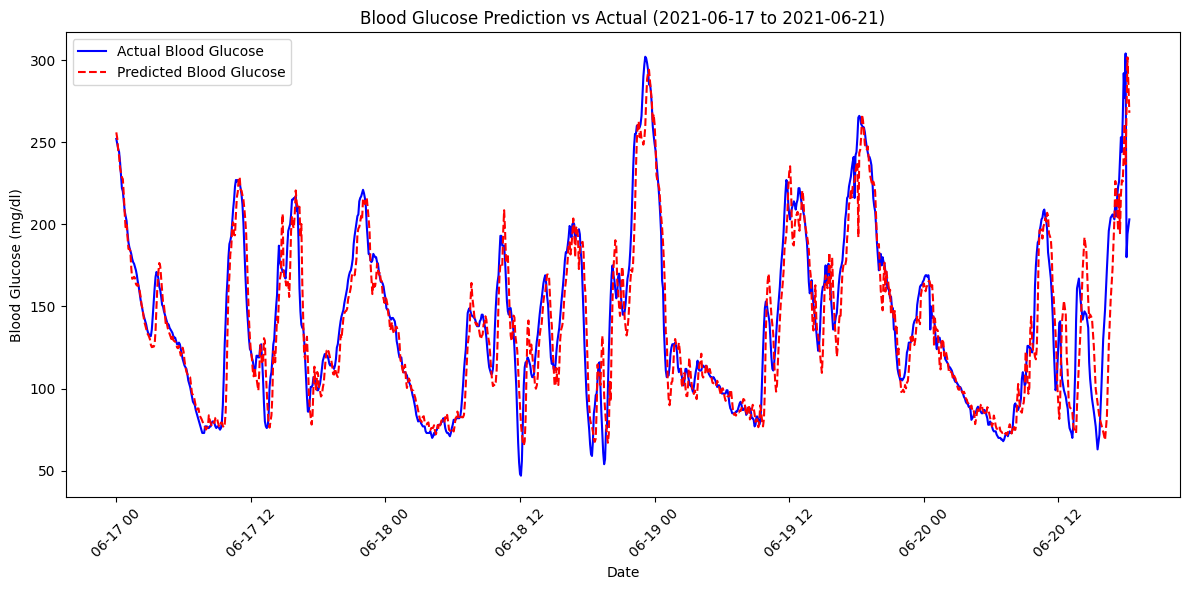

In [32]:
# Plot predictions vs actual for a given week
test_dates = merged_data['date'][train_size:].reset_index(drop=True)

def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify dates for a week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)

6

In [33]:
# Generate target variable
forecast_horizon = 6
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [34]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 146s 16ms/step - loss: 18335.8984 - mae: 112.9105 - val_loss: 2036.2050 - val_mae: 31.8351
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 204s 16ms/step - loss: 1614.3140 - mae: 29.1520 - val_loss: 974.6011 - val_mae: 22.7971
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 201s 16ms/step - loss: 1233.2617 - mae: 25.8310 - val_loss: 916.6912 - val_mae: 21.6850
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 202s 16ms/step - loss: 1191.9636 - mae: 25.3288 - val_loss: 950.9185 - val_mae: 21.9244
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 199s 16ms/step - loss: 1181.3418 - mae: 25.1347 - val_loss: 873.8152 - val_mae: 20.7669
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 144s 16ms/step - loss: 1172.1244 - mae: 25.0113 - val_loss: 890.3137 - val_mae: 21.0517
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 142s 16ms/step - loss: 1158.4769 - mae: 24.8765 - val_loss: 869.4680 - val_mae: 20.7808
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 16ms/step - loss: 1143.1897 - mae: 24.67

9

In [35]:
# Generate target variable
forecast_horizon = 9
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [36]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 150s 17ms/step - loss: 18606.9629 - mae: 114.2762 - val_loss: 2641.2202 - val_mae: 38.1479
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 146s 17ms/step - loss: 2162.5078 - mae: 34.7261 - val_loss: 1619.6370 - val_mae: 28.8481
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 201s 16ms/step - loss: 1800.2892 - mae: 31.6737 - val_loss: 1492.2994 - val_mae: 27.9689
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 148s 17ms/step - loss: 1765.0525 - mae: 31.2614 - val_loss: 1445.6340 - val_mae: 27.9492
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 200s 17ms/step - loss: 1722.4341 - mae: 30.8872 - val_loss: 1702.1016 - val_mae: 31.0981
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 140s 16ms/step - loss: 1715.4994 - mae: 30.8149 - val_loss: 1465.3457 - val_mae: 27.7503
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 143s 16ms/step - loss: 1691.3973 - mae: 30.5975 - val_loss: 1442.4557 - val_mae: 27.3331
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 145s 16ms/step - loss: 1674.9528 - mae:

12

In [37]:
# Generate target variable
forecast_horizon = 12
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [38]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 152s 17ms/step - loss: 19012.5605 - mae: 115.9611 - val_loss: 3276.6409 - val_mae: 43.5989
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 198s 16ms/step - loss: 2676.7085 - mae: 39.3330 - val_loss: 2268.5857 - val_mae: 35.9210
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 204s 17ms/step - loss: 2296.5789 - mae: 36.2377 - val_loss: 2060.4468 - val_mae: 33.8717
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 146s 17ms/step - loss: 2262.9409 - mae: 35.9037 - val_loss: 2012.6849 - val_mae: 33.2068
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 201s 16ms/step - loss: 2248.5481 - mae: 35.7974 - val_loss: 1969.9108 - val_mae: 32.8409
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 204s 17ms/step - loss: 2229.6394 - mae: 35.6874 - val_loss: 1978.1398 - val_mae: 33.2213
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 206s 17ms/step - loss: 2216.4353 - mae: 35.4981 - val_loss: 2147.5007 - val_mae: 34.6407
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 200s 17ms/step - loss: 2192.3625 - mae:

CNN

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt

# Load CGM data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

# Preprocess CGM data - Round to nearest 5 minutes and filter
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Generate lag features for CGM data
num_lags = 12  # Using the past 12 readings as features
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

# Load Bolus data
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput',
              'recommended.carb', 'recommended.net', 'recommended.correction',
              'insulinSensitivityFactor', 'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

# Drop rows with NaN due to shifting
merged_data = merged_data.dropna().reset_index(drop=True)



<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [40]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [41]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 130s 15ms/step - loss: 2501.5989 - mae: 33.8076 - val_loss: 798.0844 - val_mae: 21.7602
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 145s 15ms/step - loss: 1007.1840 - mae: 23.3491 - val_loss: 554.6957 - val_mae: 16.8293
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - loss: 955.7792 - mae: 22.8140 - val_loss: 518.0985 - val_mae: 15.8905
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 128s 15ms/step - loss: 939.5820 - mae: 22.5101 - val_loss: 547.9764 - val_mae: 16.7516
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 146s 15ms/step - loss: 924.4047 - mae: 22.3443 - val_loss: 874.5587 - val_mae: 23.3357
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2584.6238 - mae: 27.7721
Test Loss: 8918.830078125, Test MAE: 47.414756774902344
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
Root Mean Squared Error (RMSE): 94.4395955172342


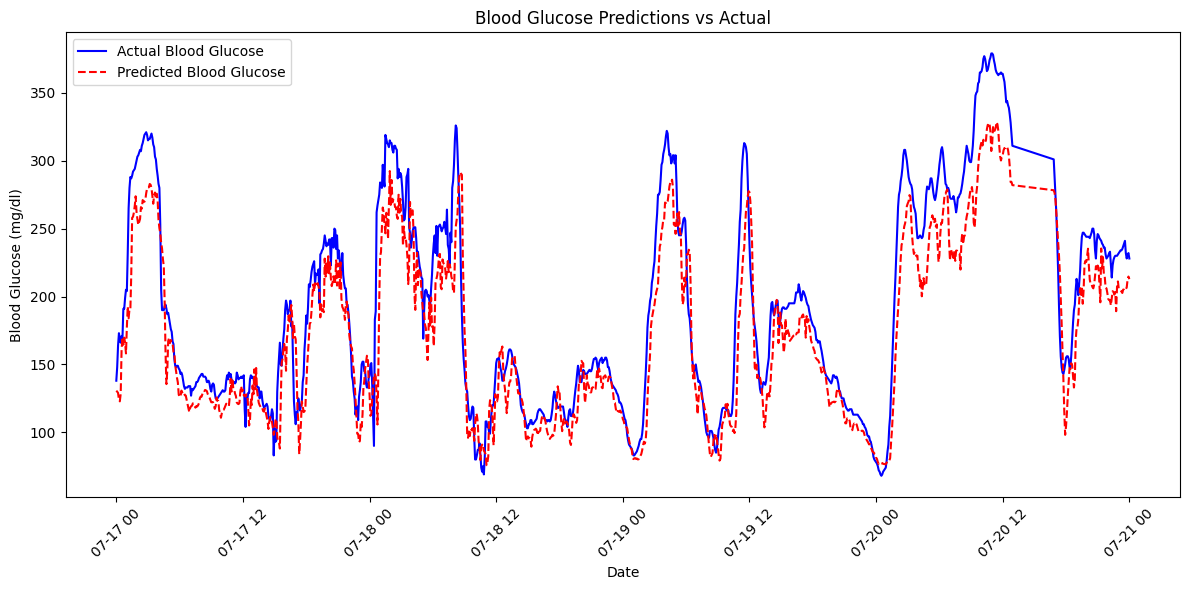

In [42]:
# Plot actual vs predicted for a specific week
def plot_predictions_for_week(data, predictions, actual, start_date, end_date):
    # Filter the test data for the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Get aligned predictions and actual values
    aligned_predictions = predictions[:len(week_data)]
    aligned_actual = actual[:len(week_data)]

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], aligned_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], aligned_predictions, label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title('Blood Glucose Predictions vs Actual')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for a specific week
plot_predictions_for_week(merged_data[train_size:], predictions, y_test, '2021-07-17', '2021-07-21')

6

In [43]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 6  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [44]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 133s 15ms/step - loss: 3036.8247 - mae: 39.0985 - val_loss: 1421.9175 - val_mae: 28.7484
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 125s 14ms/step - loss: 1520.9485 - mae: 29.0803 - val_loss: 1324.7319 - val_mae: 27.4063
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 128s 15ms/step - loss: 1444.0217 - mae: 28.2118 - val_loss: 1004.1655 - val_mae: 22.3075
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 144s 15ms/step - loss: 1411.9291 - mae: 27.8576 - val_loss: 1402.3948 - val_mae: 28.5216
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 143s 15ms/step - loss: 1381.9507 - mae: 27.5723 - val_loss: 1558.9830 - val_mae: 30.7685
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 5734.3198 - mae: 37.7504
Test Loss: 20726.59375, Test MAE: 67.77008819580078
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
Root Mean Squared Error (RMSE): 143.96735776594417


9

In [45]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 9  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [46]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 136s 15ms/step - loss: 3431.1946 - mae: 42.8042 - val_loss: 1740.0166 - val_mae: 31.1358
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 144s 15ms/step - loss: 2066.9443 - mae: 34.1805 - val_loss: 1702.5575 - val_mae: 30.4999
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - loss: 1966.9196 - mae: 33.2086 - val_loss: 1809.3440 - val_mae: 32.0047
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - loss: 1923.6443 - mae: 32.8980 - val_loss: 1994.4575 - val_mae: 34.1362
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 143s 15ms/step - loss: 1879.0548 - mae: 32.5026 - val_loss: 1636.1008 - val_mae: 30.2769
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 6683.7510 - mae: 38.2458
Test Loss: 24938.25, Test MAE: 72.81369018554688
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
Root Mean Squared Error (RMSE): 157.9184519453459


12

In [47]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 12  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [48]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 134s 15ms/step - loss: 3902.1399 - mae: 46.6180 - val_loss: 2491.6462 - val_mae: 38.2912
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 139s 15ms/step - loss: 2509.4763 - mae: 38.2339 - val_loss: 2352.0774 - val_mae: 36.7971
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 144s 15ms/step - loss: 2438.9971 - mae: 37.5354 - val_loss: 2170.1577 - val_mae: 35.3047
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 138s 14ms/step - loss: 2401.7646 - mae: 37.2027 - val_loss: 2826.6106 - val_mae: 41.0415
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 147s 15ms/step - loss: 2390.2844 - mae: 37.1447 - val_loss: 2235.3899 - val_mae: 35.3204
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 4070.9209 - mae: 39.1486
Test Loss: 11119.130859375, Test MAE: 58.74525833129883
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
Root Mean Squared Error (RMSE): 105.44728350008766


CRNN

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, TimeDistributed
import matplotlib.pyplot as plt

# Load CGM data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

# Preprocess CGM data - Round to nearest 5 minutes and filter
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Generate lag features for CGM data
num_lags = 12  # Using the past 12 readings as features
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

# Load Bolus data
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput',
              'recommended.carb', 'recommended.net', 'recommended.correction',
              'insulinSensitivityFactor', 'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

# Drop rows with NaN due to shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Create labels for prediction (15 minutes into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for RCNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [50]:
# Build RCNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 379s 43ms/step - loss: 7272.5518 - mae: 66.9080 - val_loss: 5100.4907 - val_mae: 58.6615
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 393s 45ms/step - loss: 5063.0850 - mae: 57.8501 - val_loss: 5256.5566 - val_mae: 59.2302
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 419s 42ms/step - loss: 5023.6846 - mae: 57.6592 - val_loss: 5034.8760 - val_mae: 58.4469
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 390s 44ms/step - loss: 4990.3286 - mae: 57.5043 - val_loss: 5179.9565 - val_mae: 58.9424
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 427s 43ms/step - loss: 4931.4209 - mae: 57.2014 - val_loss: 5136.9556 - val_mae: 58.7882
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - loss: 4390.6499 - mae: 53.8573
Test Loss: 3848.858154296875, Test MAE: 50.71145248413086
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step
Root Mean Squared Error (RMSE): 62.0391997223633


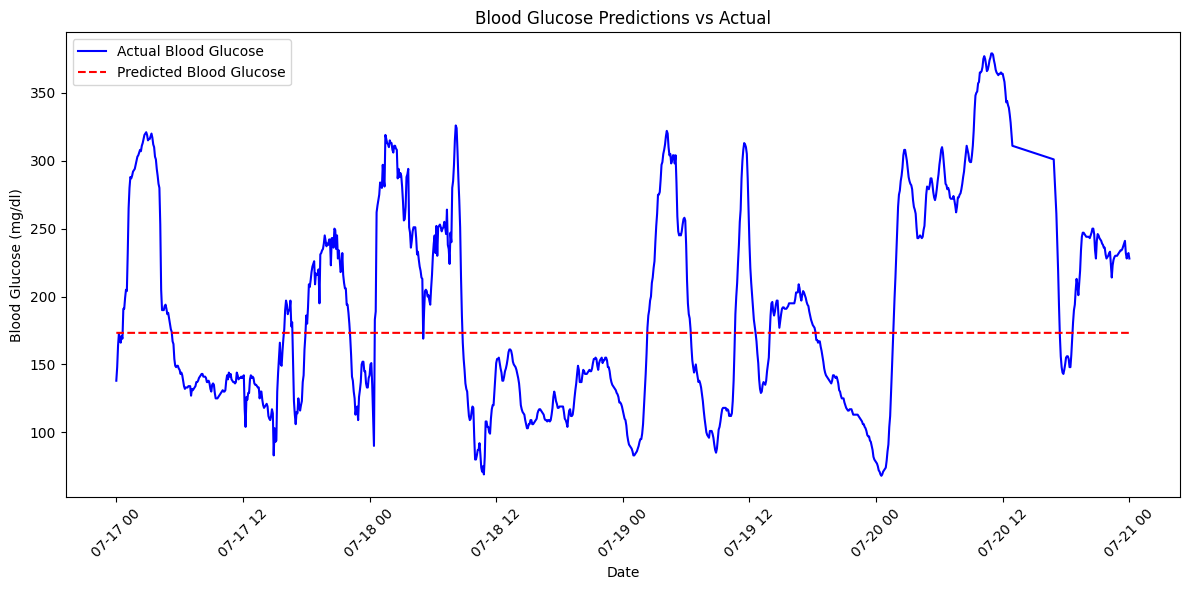

In [51]:
# Plot actual vs predicted for a specific week
def plot_predictions_for_week(data, predictions, actual, start_date, end_date):
    # Filter the test data for the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Get aligned predictions and actual values
    aligned_predictions = predictions[:len(week_data)]
    aligned_actual = actual[:len(week_data)]

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], aligned_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], aligned_predictions, label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title('Blood Glucose Predictions vs Actual')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for a specific week
plot_predictions_for_week(merged_data[train_size:], predictions, y_test, '2021-07-17', '2021-07-21')